**16. Dataset and DataLoaders in PyTorch**

*Complete dataset as single batch - gradient descent issues*
* memory inefficient for large datasets
* not very good convergence (entire dataset is looked before updation)
* Rather than loading the entire data it is better to load them in batches (mini-batch gradient descent)

In [25]:
import torch as tr
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np

In [10]:
features = 30
data_rows = 455
X_train_tensor = tr.rand(data_rows,features,dtype=tr.float32)
y_train_tensor = tr.randint(low=0,high=2,size=(data_rows,))

class Model(nn.Module):
    def __init__(self,in_features):
        super().__init__()
        self.linear = nn.Linear(in_features,5)
    def forward(self,x):
        return self.linear(x)
    
m=Model(features)
optimizer = tr.optim.SGD(m.parameters(),lr = 0.1)
loss_function = nn.CrossEntropyLoss()

# Simple approach for mini-batch training
batch_size = 32
epochs = 10
n_samples = len(X_train_tensor)

for epochi in range(epochs):
    batch_loss = []
    for start_idx in range(0,n_samples,batch_size):
        end_idx = start_idx + batch_size 
        X_batch = X_train_tensor[start_idx:end_idx]
        y_batch = y_train_tensor[start_idx:end_idx]

        # forward pass
        y_pred = m(X_batch)
        loss = loss_function(y_pred,y_batch)
        batch_loss.append(loss.item())

        # update step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    print(f'Epoch: {epochi+1}, Loss: {np.mean(batch_loss)}')

Epoch: 1, Loss: 0.9856109340985616
Epoch: 2, Loss: 0.7705310901006063
Epoch: 3, Loss: 0.733952263991038
Epoch: 4, Loss: 0.7163712859153748
Epoch: 5, Loss: 0.7052034894625346
Epoch: 6, Loss: 0.6971722682317097
Epoch: 7, Loss: 0.6910023331642151
Epoch: 8, Loss: 0.6860722025235494
Epoch: 9, Loss: 0.6820310115814209
Epoch: 10, Loss: 0.6786592324574788


*Problem with this approach:*
1. No standard interface for data
2. No easy way to apply transformations
3. Shuffling and sampling
4. Batch management & Parallelization

**Dataset and DataLoader classes**
* core abstractions in PyTorch that decouple how you define your data and how you efficiently iterate over it in training loops.
* Dataset class: essentially a blueprint. When you create a custom Dataset, you decide how data is loaded and returned. It defines:
  * `__init__()`: which tells you how data should be loaded.
  * `__len__()`: which returns the total number of samples.
  * `__getitem__(index)`: which returns the data (and label) at the given index.
    * Any kind of transformations can be done here (eg: image based data - resize, color-transformations, data-augmentation),(eg: textual data - lowercase conversion, lementization, stop-word removal etc)
* DataLoader class: It wraps the dataset and handles batching, shuffling and parallel loading for you. 
* DataLoader Control flow: 
  * At the start of each epoch, the DataLoader (if shuffle = True) shuffles indices (using a sampler).
  * It divides the indices into chunks of batch size.
  * for each index in the chunk, data samples are fetched from the Dataset object.
  * The samples are then collected and combined into a batch (using `collate_fn`).
  * The batch is returned to the main training loop.

**Parallelization**

Imagine the entire data loading and training process for one epoch with num_workers=4:<br><br>
Assumptions:
* Total samples: 10,000
* Batch size: 32
* Workers (num_workers): 4
* Approximately 312 full batches per epoch (10000 / 32 ≈ 312).

Workflow:
1. `Sampler and Batch Creation (Main Process):`<br>
    Before training starts for the epoch, the DataLoader’s sampler generates a shuffled list of all 10,000 indices. These are then grouped into 312 batches of 32 indices each. All these batches are queued up, ready to be fetched by workers.

2. `Parallel Data Loading (Workers):`<br>
At the start of the training epoch, you run a training loop like:
<pre>
    for batch_data, batch_labels in dataloader:
        # Training logic

        Under the hood, as soon as you start iterating over dataloader, 
        it dispatches the first four batches of indices to the four workers:
        ▪ Worker #1 loads batch 1 (indices [batch_1_indices])
        ▪ Worker #2 loads batch 2 (indices [batch_2_indices])
        ▪ Worker #3 loads batch 3 (indices [batch_3_indices])
        ▪ Worker #4 loads batch 4 (indices [batch_4_indices])

    Each worker:
        ○ Fetches the corresponding samples by calling __getitem__ 
        on the dataset for each index in that batch.
        ○ Applies any defined transforms and passes the samples 
        through collate_fn to form a single batch tensor.
</pre>

3. `First Batch Returned to Main Process:`
   * Whichever worker finishes first sends its fully prepared batch (e.g., batch 1) back to the main process.
   * As soon as the main process gets this first prepared batch, it yields it to your training loop, so your code for batch_data, batch_labels in dataloader:receives (batch_data, batch_labels) for the first batch.

4. `Model Training on the Main Process:`
   * While you are now performing the forward pass, computing loss, and doing backpropagation on the first batch, the other three workers are still preparing their batches in parallel.
   * By the time you finish updating your model parameters for the first batch, the DataLoader likely has the second, third, or even more batches ready to go (depending on processing speed and hardware).

5. `Continuous Processing:`
   * As soon as a worker finishes its batch, it grabs the next batch of indices from the queue. For example, after Worker #1 finishes with batch 1, it immediately starts on batch 5. After Worker #2 finishes batch 2, it takes batch 6, and so forth.
   * This creates a pipeline effect: at any given moment, up to 4 batches are being prepared concurrently.


6. `Loop Progression:`
Your training loop simply sees:
<pre>
    for batch_data, batch_labels in dataloader:
        # forward pass
        # loss computation
        # backward pass
        # optimizer step
</pre>
   * Each iteration, it gets a new, ready-to-use batch without long I/O waits, because the workers have been pre-loading and processing data in parallel.


7. `End of the Epoch:`
* After ~312 iterations, all batches have been processed. All indices have been consumed, so the DataLoader has no more batches to yield.
* The epoch ends. If shuffle=True, on the next epoch, the sampler reshuffles indices, and the whole process repeats with workers again loading data in parallel.

**Sampler**
* In PyTorch, the sampler in the DataLoader determines the strategy for selecting samples from the dataset during dataloading. It controls how indices of the dataset are drawn for each batch.
* PyTorch provides several predefined samplers and you can create  custom ones also

1. SequentialSampler:
   * Samples elements sequentially, in the order they appear in the dataset.
   * Default when shuffle = False.
2. RandomSampler:
   * Samples elements randomly without replacement.
   * Default when shuffle = True. 

**`collate_fn`**
* The `collate_fn` in PyTorch is a function that specifies how to combine a list of samples from a dataset into a single batch. By default, the DataLoader uses a simple batch collation mechanism, but collate_fn allows you to customize how the data should be processed and batched. 

**Other parameters of DataLoaders**
* pin_memory: if set True, can improve GPU transfer speed and thus overall training throughput, particularly on CUDA system.
* drop_last: if set True, DataLoader will drop the last incomplete batch if the total number of samples is not divisible by the batch size. Useful when exact batch sizes are required (for example, in some batch normalization scenarios).
* `collate_fn`: a callable that processes a list of samples into a batch (the default simply stacks tensors). Custom collate_fn can handle variable length sequences, perform custom batching logic, or handle complex data structures.
* sampler: defines the strategy for drawing samples (eg: for handling custom imbalanced classes or custom sampling strategies).

In [31]:
# creating a custom dataset
from sklearn.datasets import make_classification

# import plotting libraries
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

X,y = make_classification(
    n_samples = 10, # number of samples
    n_features = 2, # number of features
    n_informative = 2, # number of informative features 
    n_redundant = 0, # number of redundant features
    n_classes = 2, # number of classes
    random_state = 14  # for reproducibility
)

X,y

(array([[ 0.01715808, -1.63504004],
        [ 0.29491078,  0.19560103],
        [-0.54129158,  1.19824648],
        [ 1.94004845,  1.22484216],
        [ 0.25295269,  0.76694479],
        [-1.72724826, -0.43157626],
        [ 1.35830904,  0.11834559],
        [-1.10706014, -0.96892733],
        [ 1.31448879,  0.77617595],
        [ 1.05407811, -0.87015934]]),
 array([0, 1, 0, 1, 0, 0, 1, 0, 1, 1]))

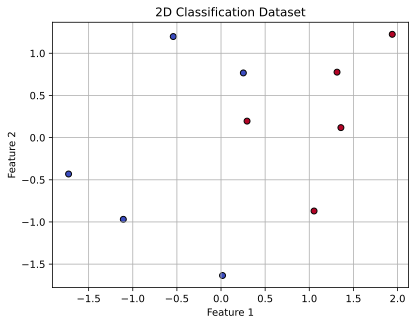

In [23]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolor='k')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('2D Classification Dataset')
plt.grid(True)
plt.show()

In [ ]:
# convert data into PyTorch tensors
X = tr.tensor(X, dtype = tr.float32)
y = tr.tensor(y, dtype = tr.long)

# creating a custom Dataset class
class CustomDataset(Dataset):
    def __init__(self,features,labels):
        self.features = features
        self.labels = labels
    
    def __len__(self):
        return self.features.shape[0]
    
    def __getitem__(self, index):
        return self.features[index],self.labels[index]

In [34]:
dataset = CustomDataset(X,y)

print(len(dataset)) 
print(dataset[0])

10
(tensor([ 0.0172, -1.6350]), tensor(0))


In [48]:
# creating the DataLoader
dataloader = DataLoader(dataset,batch_size = 2, shuffle=True,num_workers=1) # a type of iterable

In [49]:
for batch_features, batch_labels in dataloader:
    print(batch_features)
    print(batch_labels)
    print("-"*50)

tensor([[ 0.0172, -1.6350],
        [-1.1071, -0.9689]])
tensor([0, 0])
--------------------------------------------------
tensor([[ 1.3145,  0.7762],
        [-0.5413,  1.1982]])
tensor([1, 0])
--------------------------------------------------
tensor([[1.9400, 1.2248],
        [1.3583, 0.1183]])
tensor([1, 1])
--------------------------------------------------
tensor([[ 0.2530,  0.7669],
        [ 1.0541, -0.8702]])
tensor([0, 1])
--------------------------------------------------
tensor([[ 0.2949,  0.1956],
        [-1.7272, -0.4316]])
tensor([1, 0])
--------------------------------------------------


**Applying it to our previous problem**

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import pandas as pd

In [52]:
# dataset: Breast Cancer Detection
df = pd.read_csv('https://raw.githubusercontent.com/gscdit/Breast-Cancer-Detection/refs/heads/master/data.csv')

# drop columns
df.drop(columns=['id','Unnamed: 32'],inplace=True)

# Perform train-test-split
X_train,X_test,y_train,y_test = train_test_split(df.iloc[:,1:],df.iloc[:,0],test_size=0.2)

# Pre-processing (normalizing)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# label encoding
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)
y_train[:5],y_test[:5]

(array([0, 1, 0, 0, 1]), array([0, 1, 0, 0, 0]))

In [53]:
# convert to PyTorch tensors
X_train_tensor = tr.from_numpy(X_train).to(tr.float32)
X_test_tensor = tr.from_numpy(X_test).to(tr.float32)

y_train_tensor = tr.from_numpy(y_train).to(tr.float32)
y_test_tensor = tr.from_numpy(y_test).to(tr.float32)

class CustomDataset(Dataset):
    def __init__(self,features,labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return self.features.shape[0]
    
    def __getitem__(self, index):
        return self.features[index],self.labels[index]
    
train_dataset = CustomDataset(X_train_tensor,y_train_tensor)
test_dataset = CustomDataset(X_test_tensor,y_test_tensor)

BATCH_SIZE = 32 
train_dataloader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
test_dataloader = DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=True) 

In [54]:
class hNet(nn.Module):
    def __init__(self,input_size):
        super().__init__()
        self.linear1 = nn.Linear(in_features=input_size,out_features=3)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(in_features=3,out_features=1)
        self.sigmoid = nn.Sigmoid()
    

    def forward(self,x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.sigmoid(x)
        return x
    
# important parameter of Neural Network
learning_rate = 0.1
epochs = 25

In [57]:
### model training
model = hNet(X_test_tensor.shape[1])

# loss function
loss_function = nn.BCELoss()

# define optimizer 
optimizer = tr.optim.SGD(model.parameters(),lr = learning_rate)

# Loop no of epochs:
for epochi in range(epochs):
    batch_loss = []
    for X_batch,y_batch in train_dataloader:
        # 1. Forward pass
        y_pred = model(X_batch)

        # 2. Loss Calculation
        loss = loss_function(y_pred,y_batch.view(-1,1))

        # 5. zero gradients (stop accumulation of gradient) [Better strategy to clear first]
        optimizer.zero_grad()

        # 3. Backward pass
        loss.backward()

        # 4. Update parameters 
        optimizer.step() # no-need to disable gradients, it does it automatically
    
        batch_loss.append(loss.item())


    # 6. printing loss in each epoch
    print(f'Epoch: {epochi+1}, Loss:{np.mean(batch_loss)}')

Epoch: 1, Loss:0.7130202968915303
Epoch: 2, Loss:0.6400190949440002
Epoch: 3, Loss:0.49092236161231995
Epoch: 4, Loss:0.31444102426369985
Epoch: 5, Loss:0.21752405762672425
Epoch: 6, Loss:0.17987799644470215
Epoch: 7, Loss:0.14658964176972708
Epoch: 8, Loss:0.1366995910803477
Epoch: 9, Loss:0.11889066795508067
Epoch: 10, Loss:0.11471926520268122
Epoch: 11, Loss:0.10219087786972522
Epoch: 12, Loss:0.097211042791605
Epoch: 13, Loss:0.09200411761800448
Epoch: 14, Loss:0.08680396676063537
Epoch: 15, Loss:0.08929141374925773
Epoch: 16, Loss:0.08090725094079972
Epoch: 17, Loss:0.07821218383808931
Epoch: 18, Loss:0.08240122658511002
Epoch: 19, Loss:0.07351904064416885
Epoch: 20, Loss:0.07159639553477366
Epoch: 21, Loss:0.0697659634364148
Epoch: 22, Loss:0.06916782644887766
Epoch: 23, Loss:0.08608306857446829
Epoch: 24, Loss:0.06787333550552527
Epoch: 25, Loss:0.06583241919676462


In [73]:
import torch as tr
import numpy as np

model.eval()  # set the model to evaluation mode
accuracy_list = []
thresh = 0.5

with tr.no_grad():
    for batch_features, batch_labels in test_dataloader:
        y_pred = model(batch_features)
        y_pred_thresh = (y_pred > thresh).int().squeeze()  # tensor of 0s and 1s

        batch_labels = batch_labels.int().squeeze()  # ensure same shape and type

        correct = (y_pred_thresh == batch_labels).sum().item()
        total = batch_labels.size(0)
        accuracy = (correct / total) * 100
        accuracy_list.append(accuracy)

print(f'Mean Accuracy: {np.mean(accuracy_list):.2f}%')


Mean Accuracy: 97.05%
